In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import math
from tqdm import tqdm
import seaborn as sns
from IPython.display import display, Markdown
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import geopandas as gpd
import pandas as pd
import matplotlib.colors as mcolors
import imageio.v2 as imageio
import os
import tempfile
from PIL import Image, ImageDraw, ImageFont
from IPython.display import HTML
from scipy.optimize import minimize
from scipy.integrate import odeint

In [11]:
with open("Proper_London_Patch_Populations_1_5km_fixed.pkl", "rb") as file:
    pop_dict = pickle.load(file)

small_pop_vector = np.array(list(pop_dict.values()))
pop_vector = np.zeros(63001)  # Create a zero array of the desired size

# Assign values at the correct positions
pop_vector[np.arange(251) * (251 + 1)] = small_pop_vector


with open("London Borough List.pkl", 'rb') as f:
    borough_list = pickle.load(f)
    
with open("London Station List.pkl", "rb") as file:
    station_list = pickle.load(file)
    
with open("London Subpopulation List.pkl", 'rb') as f:
    subpop_list = pickle.load(f)
    
with open("London Completed Commuter Matrix.pkl", "rb") as file:
    completed_commuter_matrix = pickle.load(file)

with open("London Home Patch Indices.pkl", "rb") as file:
    home_patches = pickle.load(file)
    
with open("London Travel Patch Indices.pkl", "rb") as file:
    travel_patches = pickle.load(file)

with open("London Travel Patch Names.pkl", "rb") as file:
    travel_patch_names = pickle.load(file)
    
with open("London new Nj.pkl", "rb") as file:
    Nj = pickle.load(file)

with open("London N=0 Indices Set.pkl", "rb") as file:
    N_0_set = pickle.load(file)

with open("London Station Borough List.pkl", 'rb') as f:
    station_borough_list = pickle.load(f)

with open("London Unique Patches.pkl", 'rb') as f:
    valid_patches = pickle.load(f)
    
with open("London Valid Patch Indices.pkl", 'rb') as f:
    valid_patch_indices = pickle.load(f)

with open("London Nonempty Subpopulation Indices.pkl", 'rb') as f:
    nonempty_subpop_indices = pickle.load(f)

with open("London Travel Patch Names.pkl", "rb") as file:
    travel_patch_names = pickle.load(file)

with open("final_best_beta_with_R.pkl", "rb") as file:
    betas = pickle.load(file)
    
covid_df = pd.read_csv("phe_cases_london_boroughs_fixed.csv")

borough_populations = pd.read_csv("london population 1801 to 2021_cleaned.csv")

london_gdf = gpd.read_file("Complete London Shapefile.gpkg", layer="Combined_London_Data")

london_commuters = pd.read_csv("London Commuters.csv").dropna(axis=1, how='all').dropna(axis=0, how='all')

london_tickets = pd.read_csv("London Ticket Data.csv").dropna(axis=0, how='all').dropna(axis=1, how='all')

In [3]:
london_tickets

,Station,Borough,Weekday traffic
0,Acton Town,Ealing,18797.0
1,Aldgate,"Westminster,City of London",25746.0
2,Aldgate East,Tower Hamlets,37843.0
3,Alperton,Brent,9896.0
4,Angel,Islington,59496.0
...,...,...,...
246,Wimbledon,Merton,48810.0
247,Wimbledon Park,Merton,5850.0
248,Wood Green,Haringey,39845.0
249,Woodford,Redbridge,18733.0


In [12]:
london_commuters

,"Rows - Residence, Columns - Work",Barking & Dagenham,Barnet,Brent,Camden,Ealing,Enfield,Greenwich,Hackney,Hammersmith & Fulham,...,Newham,Redbridge,Richmond upon Thames,Southwark,Tower Hamlets,Waltham Forest,Wandsworth,"Westminster,City of London",Total,Work from home
0,Barking & Dagenham,14650,280,290,1855,250,653,412,1228,433,...,4829,5389,41,1218,4279,1292,235,6350,53533,4764
1,Barnet,144,36031,5908,14006,1787,4457,250,1866,1741,...,601,338,383,2357,3461,585,567,24662,117038,21611
2,Brent,56,6268,27338,8735,8195,678,221,953,4349,...,435,145,522,2061,2405,276,846,22519,105401,13058
3,Camden,51,1918,1677,23151,718,415,216,1636,2133,...,370,81,303,2507,4192,254,594,29719,81710,14893
4,Ealing,53,1268,6238,4956,34302,330,200,740,9360,...,374,93,1970,1868,2154,197,1161,19381,118095,15343
5,Enfield,344,6641,1140,6241,664,37198,260,2973,1012,...,1006,693,134,1859,2758,2193,401,13690,98440,12531
6,Greenwich,328,317,434,3835,310,283,23759,1186,944,...,1656,223,170,5689,6884,437,904,17009,72196,9731
7,Hackney,273,1022,706,9760,592,1205,449,18889,1761,...,1680,489,196,3351,7259,1653,732,21861,89646,12060
8,Hammersmith & Fulham,20,401,1162,4674,2665,156,133,679,16192,...,248,38,1147,1938,2734,115,2076,26202,76477,10603
9,Haringey,218,3439,1138,11983,776,4954,317,4511,1834,...,841,424,234,2582,3287,1404,594,21687,89880,12640


In [13]:
# Let's make a toy model!

import pandas as pd

data = [
    [1, 1000, 200, 800,425],
    [2, 100, 500, 200,320],
    [3, 500, 100, 600,500]
]

toy_commuters = pd.DataFrame(data, columns=["Rows - Residence, Columns - Work", 1, 2, 3,"Work from home"])

toy_borough_list = [1,2,3]
toy_station_list = ['A','B','C','D','E','F','G']

toy_traffic_data = [1200, 3400, 2900, 3, 5, 3800, 2600]  # Replace these with your own numbers
toy_borough_data = [1,1,1,2,2,3,3]

toy_tickets = pd.DataFrame({'Station': toy_station_list, 'Borough': toy_borough_data, 'Weekday traffic': toy_traffic_data})

toy_pop_dict = {
    'A': 800,
    'B': 1000,
    'C': 200,
    'D': 300,
    'E': 500,
    'F': 600,
    'G': 600
}

toy_small_pop_vector = np.array(list(toy_pop_dict.values()))
toy_pop_vector = np.zeros(49)  # Create a zero array of the desired size

# Assign values at the correct positions
toy_pop_vector[np.arange(7) * (7 + 1)] = toy_small_pop_vector

def make_p_pops_home(stations, boroughs, commuters, tickets, pops):
    size = len(stations)
    p_pops = np.zeros((size, size))

    station_to_borough = dict(zip(tickets['Station'], tickets['Borough']))
    borough_to_stations = {b: tickets[tickets['Borough'] == b]['Station'].tolist() for b in boroughs}

    for b in boroughs:
        station_list = borough_to_stations[b]
        station_idx = [stations.index(s) for s in station_list]

        c_row = commuters.loc[commuters["Rows - Residence, Columns - Work"] == b].iloc[0]
        total_home = c_row["Work from home"]
        total_live_work = c_row[b]

        station_pops = pops[station_idx]
        pops_frac = station_pops_frac = station_pops / np.sum(station_pops)

        # Step 1: Work-from-home allocation
        home_workers = total_home * pops_frac
        for idx, s in enumerate(station_idx):
            p_pops[s, s] += home_workers[idx]

        # Step 2.1: People who work in the same borough—home station assignment
        remaining_workers = total_live_work - total_home
        people_living_at_station = remaining_workers * (pops[station_idx] / pops[station_idx].sum())

        # Step 2.2: Assign these workers to stations based on traffic proportions
        station_traffic = tickets.loc[tickets["Borough"] == b, "Weekday traffic"].values
        traffic_frac = station_traffic / station_traffic.sum()

        for i, origin in enumerate(station_idx):
            for j, destination in enumerate(station_idx):
                workers_to_station = people_living_at_station[i] * (station_traffic[j] / station_traffic.sum())
                p_pops[origin, destination] += workers_to_station

    return p_pops

def make_p_pops_away(stations, boroughs, commuters, tickets, pops):
    size = len(stations)
    p_pops = np.zeros((size, size))

    station_to_borough = dict(zip(tickets['Station'], tickets['Borough']))
    borough_to_stations = {b: [s for s, br in station_to_borough.items() if br == b] for b in boroughs}

    for b in boroughs:
        station_idx = [stations.index(s) for s in borough_to_stations[b]]

        # commuters data
        c_row = commuters.loc[commuters["Rows - Residence, Columns - Work"] == b].iloc[0]
        total_home = c_row["Work from home"]
        total_live_work = c_row[b]
        total_leave = c_row.drop(["Rows - Residence, Columns - Work", b, "Work from home"]).sum()

        pops_borough = pops[station_idx]
        pops_frac = pops_borough / pops_borough.sum()
        
        traffic_borough = tickets.loc[tickets['Borough'] == b, 'Weekday traffic'].values
        traffic_frac = traffic_borough / traffic_borough.sum()

        # Home workers allocation
        home_workers = total_home * pops_frac
        np.fill_diagonal(p_pops[np.ix_(station_idx, station_idx)], home_workers)

        # Self workers allocation
        remaining_workers = total_live_work - total_home
        self_workers = remaining_workers * traffic_frac
        np.fill_diagonal(p_pops[np.ix_(station_idx, station_idx)], 
                         np.diagonal(p_pops[np.ix_(station_idx, station_idx)]) + self_workers)

        # Leaving commuters allocation
        leaving_commuters = total_leave * pops_frac
        for dest_b in boroughs:
            if dest_b == b:
                continue
            dest_stations = borough_to_stations[dest_b]
            dest_idx = [stations.index(s) for s in dest_stations]
            dest_traffic = tickets.loc[tickets['Borough'] == dest_b, 'Weekday traffic'].values
            dest_traffic_frac = dest_traffic / dest_traffic.sum()

            commuters_to_dest = c_row[dest_b] * pops_frac
            for i, origin in enumerate(station_idx):
                for j, dest in enumerate(dest_idx):
                    p_pops[origin, dest] += commuters_to_dest[i] * dest_traffic_frac[j]

    return p_pops

def make_p_pops(stations, boroughs, commuters, tickets, pops):
    p_pops_result_home = np.round(make_p_pops_home(stations, boroughs, commuters, tickets, pops),4)
    p_pops_result_away = np.round(make_p_pops_away(stations, boroughs, commuters, tickets, pops),4)
    full_p_pops = p_pops_result_home+p_pops_result_away
    return full_p_pops

# Run the function
p_pops_result = make_p_pops(toy_station_list, toy_borough_list, toy_commuters, toy_tickets, toy_small_pop_vector)

# Check if sum of first three rows is 2000
print(f"\nSanity check sum (should be 2000): {np.round(np.sum(p_pops_result[:3]),4)}")

p_pops_result


Sanity check sum (should be 2000): 2000.0


array([[206.8   , 104.2667,  88.9333,  30.    ,  50.    , 190.    ,
        130.    ],
       [ 46.    , 342.8333, 111.1667,  37.5   ,  62.5   , 237.5   ,
        162.5   ],
       [  9.2   ,  26.0667,  64.7333,   7.5   ,  12.5   ,  47.5   ,
         32.5   ],
       [  6.    ,  17.    ,  14.5   , 145.3125,  42.1875,  44.5312,
         30.4688],
       [ 10.    ,  28.3333,  24.1667,  42.1875, 270.3125,  74.2188,
         50.7812],
       [ 40.    , 113.3333,  96.6667,  18.75  ,  31.25  , 279.6875,
         20.3125],
       [ 40.    , 113.3333,  96.6667,  18.75  ,  31.25  ,  29.6875,
        270.3125]])

In [14]:
# Run the function
p_pops_result = make_p_pops(station_list, borough_list, london_commuters, london_tickets, small_pop_vector)


p_pops_result

array([[1.3452709e+03, 1.4017400e+01, 1.3296500e+01, ..., 4.8116000e+00,
        1.1213000e+00, 4.8365000e+00],
       [4.1130000e-01, 7.4656400e+01, 2.0121000e+00, ..., 2.4440000e-01,
        5.8600000e-02, 1.5010000e-01],
       [2.3165000e+00, 1.5296100e+01, 6.1428320e+02, ..., 5.7812000e+00,
        5.5379000e+00, 1.2220000e+00],
       ...,
       [9.9085000e+00, 2.9068100e+01, 3.7602500e+01, ..., 1.9302015e+03,
        9.4736000e+00, 2.4309100e+01],
       [3.9631000e+00, 1.6561500e+01, 7.3930900e+01, ..., 2.3985700e+01,
        1.3886246e+03, 3.2675000e+00],
       [9.4214000e+00, 1.3648600e+01, 1.6347900e+01, ..., 4.9318300e+01,
        3.1182000e+00, 1.3512195e+03]])

In [15]:
p_pops_result.shape

(251, 251)

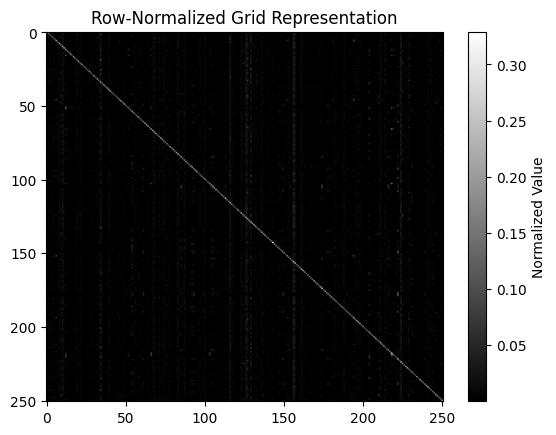

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Normalize by row (each row sums to 1)
p_pops_result2 = p_pops_result / p_pops_result.sum(axis=1, keepdims=True)

# Plot the result as a grayscale image
plt.imshow(p_pops_result2, cmap='gray', aspect='auto')
plt.colorbar(label="Normalized Value")
plt.title("Row-Normalized Grid Representation")
plt.show()


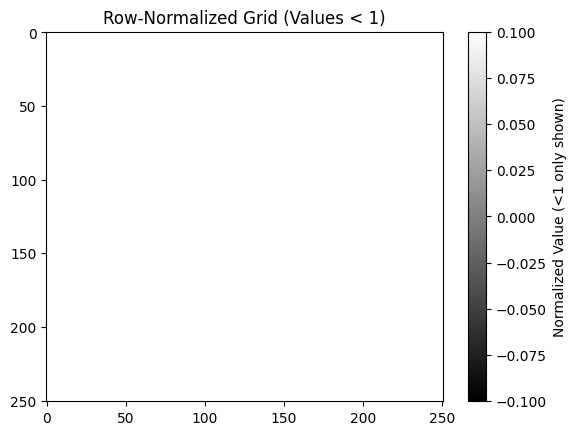

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Normalize by row (each row sums to 1)
p_pops_result2 = p_pops_result / p_pops_result.sum(axis=1, keepdims=True)

# Mask values >= 1
masked = np.ma.masked_where(p_pops_result2 >= 0, p_pops_result2)

# Plot with grayscale (masked values show as white)
plt.imshow(masked, cmap='gray', aspect='auto')
plt.colorbar(label="Normalized Value (<1 only shown)")
plt.title("Row-Normalized Grid (Values < 1)")
plt.show()


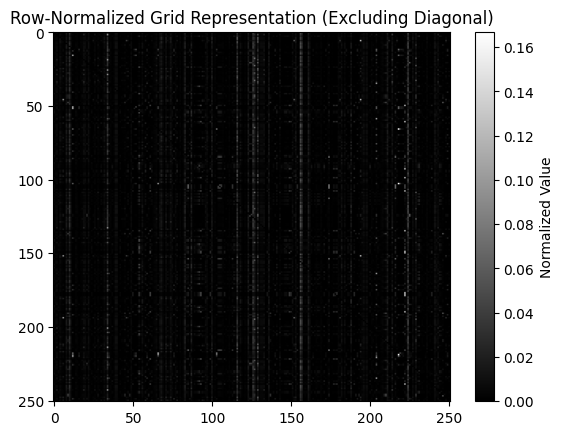

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Copy the original matrix to avoid modifying the input
p_pops_result2 = p_pops_result.copy()

# Set diagonal elements to zero for normalization
np.fill_diagonal(p_pops_result2, 0)

# Normalize by row (excluding diagonal)
row_sums = p_pops_result2.sum(axis=1, keepdims=True)
p_pops_result2 = np.divide(p_pops_result2, row_sums, where=row_sums != 0)

# Plot the result as a grayscale image
plt.imshow(p_pops_result2, cmap='gray', aspect='auto')
plt.colorbar(label="Normalized Value")
plt.title("Row-Normalized Grid Representation (Excluding Diagonal)")
plt.show()


In [19]:
import pickle

# Save the array to a file
# with open("London P Populations.pkl", "wb") as f:
    # pickle.dump(p_pops_result, f)